<a href="https://colab.research.google.com/github/gozherie/Travel-guide/blob/main/Copy_of_Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHAS0102 - Assignment 4 (21078590)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

## Laplacian Matrix Deduction

The heat equation of the system:
$$
u_t = \Delta u
$$
By Using the concept of discretization, the square plane can be divided into an $N \times N$ grid, where the spacing between grid points is $h = \frac{L}{N}$, where in this case $L=2$.

Using finite difference approximation to compute derivatives,
$$
\Delta u_{i, j}\approx -\frac{4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}}{h^2}
$$
Time is also discretized into time steps, where
$$
u_t = \frac{u_{i,j}^{t+1} - u_{i,j}^{t}}{dt}
$$

The boundary condition is that on the edge of the plane, $u=5$ on one side and $u=0$ on the other sides, and $\frac{du_{boundary}}{dt} = 0$. Therefore, we only need to compute the **interior points** of the grid(plane). The interior points of the first row are affected by the upper boundary (temperature of $5$).

### Explicit Method

After discretizing time, the explicit method directly calculates the temperature at each point for the next time step based on the temperature at the current time step:
$$
u_{i,j}^{t+1} = u_{i,j}^{t} + (\frac{dt}{h^2})(u_{i+1,j}^{t} + u_{i-1,j}^{t} + u_{i,j+1}^{t} + u_{i,j-1}^{t} - 4u_{i,j}^{t})
$$


This can be write in matrix-vector form $Au^t=u^{t+1}$ where
$$
A =
\begin{pmatrix}
1-4r&r&0&r&0&...&0\\
r&1-4r&r&0&r&...&0\\
0&r&1-4r&r&0&...&0\\
r&...&...&...&...&...&r\\
...&...&...&r&1-4r&r&0\\
...&...&...&0&r&1-4r&r\\
0&0&0&r&0&r&1-4r
\end{pmatrix}
$$


In [ ]:
def build_laplacian_matrix(N, r, method):
  # Internal points
  n = (N-2)*(N-2)

  # Construct diagonals
  if method == 'implicit':
    main_diag = np.ones(n)*(1+4*r)
    side_diag = np.ones(n-1)*(-r)
    up_down_diag = np.ones(n-(N-2))*(-r)
  else:  # explicit
    main_diag = np.ones(n)*(1-4*r)
    side_diag = np.ones(n-1)*r
    up_down_diag = np.ones(n-(N-2))*r

  # Correcting the diagonals
  for i in range(N-3, n-1, N-2):
    side_diag[i] = 0

  # Diagonals of the matrix
  diagonals = [main_diag, side_diag, side_diag, up_down_diag, up_down_diag]
  positions = [0, 1, -1, N-2, -(N-2)]

  A = diags(diagonals, positions).toarray()

  return A

A = build_laplacian_matrix(5, 0.25, method='implicit')
print(A)

[[ 2.   -0.25  0.   -0.25  0.    0.    0.    0.    0.  ]
 [-0.25  2.   -0.25  0.   -0.25  0.    0.    0.    0.  ]
 [ 0.   -0.25  2.    0.    0.   -0.25  0.    0.    0.  ]
 [-0.25  0.    0.    2.   -0.25  0.   -0.25  0.    0.  ]
 [ 0.   -0.25  0.   -0.25  2.   -0.25  0.   -0.25  0.  ]
 [ 0.    0.   -0.25  0.   -0.25  2.    0.    0.   -0.25]
 [ 0.    0.    0.   -0.25  0.    0.    2.   -0.25  0.  ]
 [ 0.    0.    0.    0.   -0.25  0.   -0.25  2.   -0.25]
 [ 0.    0.    0.    0.    0.   -0.25  0.   -0.25  2.  ]]


In [ ]:
def solve_explicit(N):
  """
  Solves the heat equation using explicit method.

  Inputs:
  - N: number of discretisation points

  Outputs:
  - u_2d: temperature of internal in 2d array
  - center_temps: list of center temperatures at each time step
  """
  # Parameters
  h = 2/(N)
  dt = h**2/4
  r = dt/h**2
  T = 1
  A = build_laplacian_matrix(N, r, 'explicit')

  # Initialization
  n = (N-2)*(N-2)  # internal points
  u = np.zeros(n)
  b = np.zeros(n)
  b[0:N-2] += 5*r  # boundary condition
  center_idx = n//2
  center_temps = []
  t = 0

  # Time iteratives
  while t < T:
    u_next = A @ u + b

    # Record center temperature
    center_temps.append(u[center_idx])

    # Check if center temp reaches 1
    if abs(u[center_idx] - 1.0) < 1e-3:
      break

    u = u_next
    t += dt

  u_2d = u.reshape((N-2, N-2))

  return u_2d, t, center_temps, dt

Time to reach temperature 1 at center: 0.411911111111


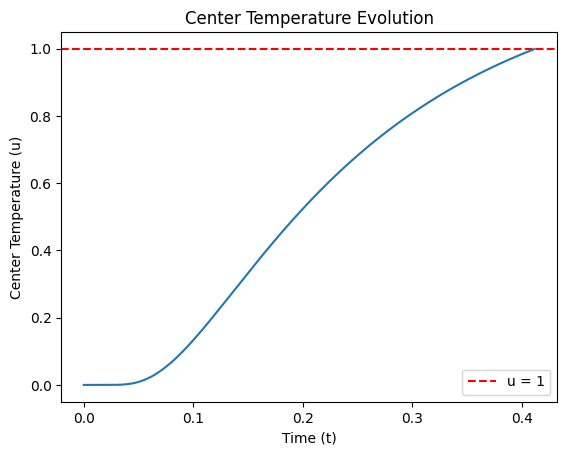

In [ ]:
u, t_final, center_temps, dt = solve_explicit(75)

print(f"Time to reach temperature 1 at center: {t_final:.12f}")
plt.plot(np.arange(len(center_temps)) * dt, center_temps)
plt.axhline(1, color='red', linestyle='--', label='u = 1')
plt.xlabel('Time (t)')
plt.ylabel('Center Temperature (u)')
plt.legend()
plt.title('Center Temperature Evolution')
plt.show()

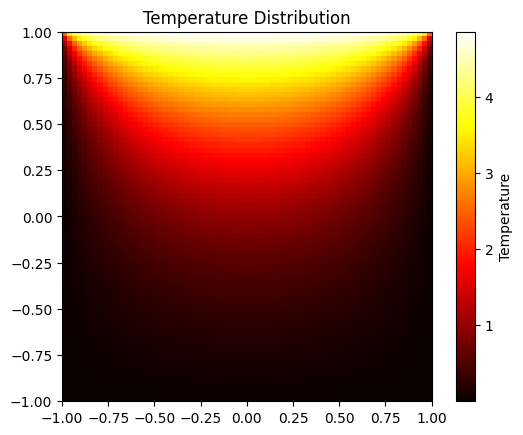

In [ ]:
plt.imshow(u, extent = (-1,1,-1,1,), cmap='hot', interpolation='nearest')
plt.colorbar(label='Temperature')
plt.title('Temperature Distribution')
plt.show()

### Implicit Method
The implicit method requires solving an equation (or a system of equations) to obtain the values at the next time step:
$$
u_{i,j}^{t} = -r(u_{i-1,j}^{t+1} + u_{i+1,j}^{t+1} + u_{i,j-1}^{t+1} + u_{i,j+1}^{t+1}) + (1+4r)u_{i,j}^{t+1}
$$
Similarly, this can be represented in matrix-vector form $Au^{t+1}=u^t$, where
$$
A =
\begin{pmatrix}
1+4r&-r&0&-r&0&...&0\\
-r&1+4r&-r&0&-r&...&0\\
0&r&1+4r&-r&0&...&0\\
-r&...&...&...&...&...&-r\\
...&...&...&-r&1+4r&-r&0\\
...&...&...&0&-r&1+4r&-r\\
0&0&0&-r&0&-r&1+4r
\end{pmatrix}
$$
By solving the equation (using spsolve), we can obtain $u^{t+1}$.

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

def solve_implicit(N):
  """
  Solves the heat equation using implicit method.

  Inputs:
  - N: number of discretisation points

  Outputs:
  - u_2d: temperature of internal in 2d array
  - center_temps: list of center temperatures at each time step
  """
  # Parameters
  dx = 2/(N-1)
  dt = dx**2/4
  r = dt/dx**2
  T = 1
  A = build_laplacian_matrix(N, r, 'implicit')
  B = csr_matrix(A)  # convert to csr format

  # Initialisation
  n = (N-2)*(N-2)  # internal points
  u = np.zeros(n)
  b = np.zeros(n)
  b[0:N-2] += 5*r  # boundary condition
  center_idx = n//2
  center_temps = []
  t = 0

  # Time iteratives
  while t < T:
    rhs = u + b # right hand side of the equation
    u_next = spsolve(B, rhs)

    # Record center temperature
    center_temps.append(u_next[center_idx])

    # Check if center temp reaches 1
    if abs(u_next[center_idx] - 1.0) < 1e-3:
      break

    u = u_next
    t += dt

  u_2d = u.reshape((N-2, N-2))

  return u_2d, t, center_temps, dt


Time to reach temperature 1 at center: 0.423301680058


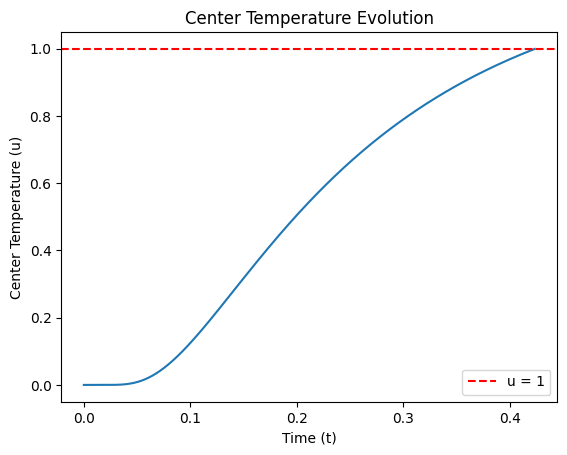

In [ ]:
u2, t_final2, center_temps2, dt2 = solve_implicit(75)

print(f"Time to reach temperature 1 at center: {t_final2:.12f}")
plt.plot(np.arange(len(center_temps2)) * dt2, center_temps2)
plt.axhline(1, color='red', linestyle='--', label='u = 1')
plt.xlabel('Time (t)')
plt.ylabel('Center Temperature (u)')
plt.legend()
plt.title('Center Temperature Evolution')
plt.show()

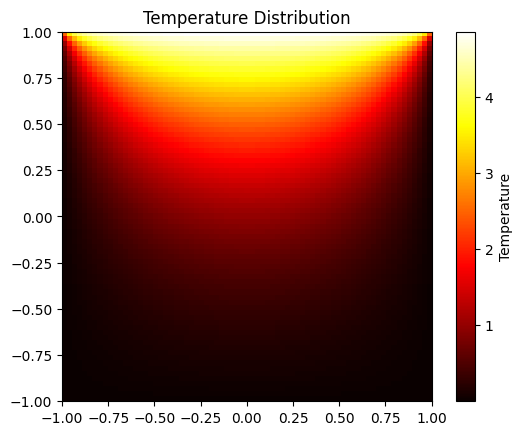

In [ ]:
plt.imshow(u2, extent = (-1,1,-1,1,), cmap='hot', interpolation='nearest')
plt.colorbar(label='Temperature')
plt.title('Temperature Distribution')
plt.show()

## Investigating the number of discretization points.

In [ ]:
N_sizes = np.arange(15, 160, 20)
times_explicit = []
times_implicit = []
error_explicit = []
error_implicit = []
t_exact = 0.424011387033

for N in N_sizes:
    _, t_e, _, _ = solve_explicit(N)
    _, t_i, _, _ = solve_implicit(N)
    times_explicit.append(t_e)
    times_implicit.append(t_i)
    error_explicit.append(abs(t_e - t_exact))
    error_implicit.append(abs(t_i - t_exact))

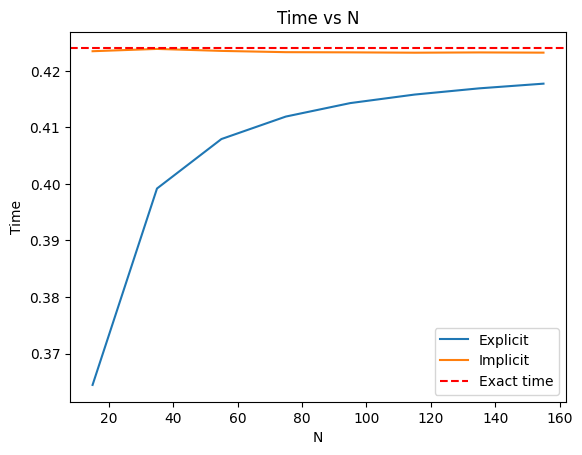

In [ ]:
plt.figure()
plt.plot(N_sizes, times_explicit, label='Explicit')
plt.plot(N_sizes, times_implicit, label='Implicit')
plt.axhline(t_exact, color='red', linestyle='--', label='Exact time')
plt.xlabel('N')
plt.ylabel('Time')
plt.title('Time vs N')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

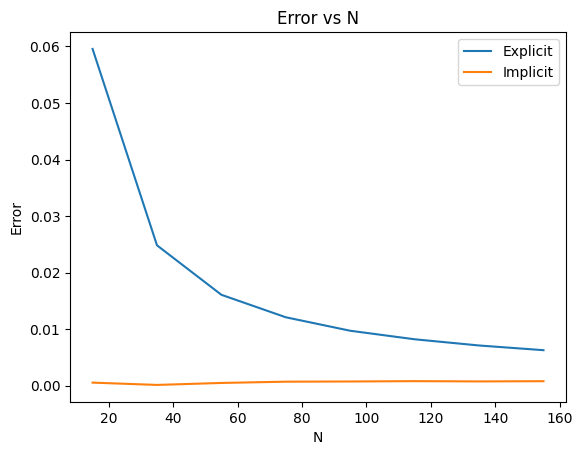

In [ ]:
plt.figure()
plt.plot(N_sizes, error_explicit, label='Explicit')
plt.plot(N_sizes, error_implicit, label='Implicit')
plt.xlabel('N')
plt.ylabel('Error')
plt.title('Error vs N')
plt.legend()
plt.show

## GPU acceleration of the explicit method

In [ ]:
import numpy as np
from numba import cuda
import math

@cuda.jit
def heat_step_kernel(u, u_next, b, N, r):
    """CUDA kernel for one time step of heat equation"""
    # Get thread position
    idx = cuda.grid(1)
    n = (N-2)*(N-2)

    if idx < n:  # Check if thread is within bounds
        # Calculate row and col from idx
        row = idx // (N-2)
        col = idx % (N-2)

        # Skip boundary points
        if row > 0 and row < N-3 and col > 0 and col < N-3:
            # Get indices of neighboring points
            up = idx - (N-2)
            down = idx + (N-2)
            left = idx - 1
            right = idx + 1

            # Update temperature using explicit method
            u_next[idx] = u[idx] + (u[up] + u[down] + u[left] + u[right] - 4*u[idx])*r + b[idx]

def solve_explicit_cuda(N):
    # Parameters
    h = 2/N
    dt = h**2/4
    r = dt/h**2
    T = 1

    # Initialization
    n = (N-2)*(N-2)
    u = np.zeros(n, dtype=np.float64)
    b = np.zeros(n, dtype=np.float64)
    b[0:N-2] += 5*r  # boundary condition

    # Calculate center index correctly
    mid_i = (N-2)//2
    mid_j = (N-2)//2
    center_idx = mid_i * (N-2) + mid_j

    center_temps = []
    t = 0

    # CUDA setup
    threadsperblock = 256
    blockspergrid = math.ceil(n / threadsperblock)

    # Allocate device memory
    d_u = cuda.to_device(u)
    d_u_next = cuda.to_device(u)
    d_b = cuda.to_device(b)

    while t < T:
        # Launch kernel with r parameter
        heat_step_kernel[blockspergrid, threadsperblock](d_u, d_u_next, d_b, N, r)

        # Copy center temperature back to host for checking
        u = d_u_next.copy_to_host()
        center_temps.append(u[center_idx])

        # Check if center temp reaches 1
        if abs(u[center_idx] - 1.0) < 1e-3:
            break

        # Swap arrays for next iteration
        d_u, d_u_next = d_u_next, d_u
        t += dt

    # Get final result and reshape
    u = d_u.copy_to_host()
    u_2d = u.reshape((N-2, N-2))

    return u_2d, t, center_temps, dt


In [ ]:
u3, t_final3, center_temps3, dt3 = solve_explicit_cuda(75)
print(f"Time to reach temperature 1: {t_final:.6f}")

Time to reach temperature 1: 0.411911
